In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Clustering, Initializers
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from functools import partial

2025-04-23 13:47:21.128482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 13:47:21.144234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 13:47:21.149186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745408842.469496 4041552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745408842.509232 4041552 cuda_executor.cc:1015] succ

## learnMSA tree demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

### Ungapped alignment

In [2]:
name = "3_200"
suffix = "_short"

# unaligned sequences
train_filename = f"../trees/data/dev_msa/{name}{suffix}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/data/dev_trees/{name}.nwk"

# number of distinct pHMMs
num_models = 5

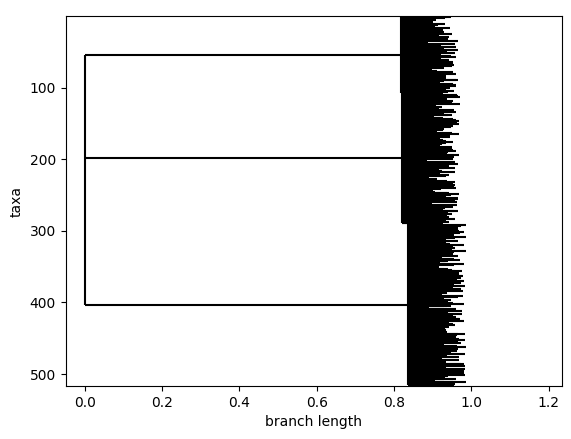

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

Problem: How to do that without computing emissions and transitions w.r.t. all models?

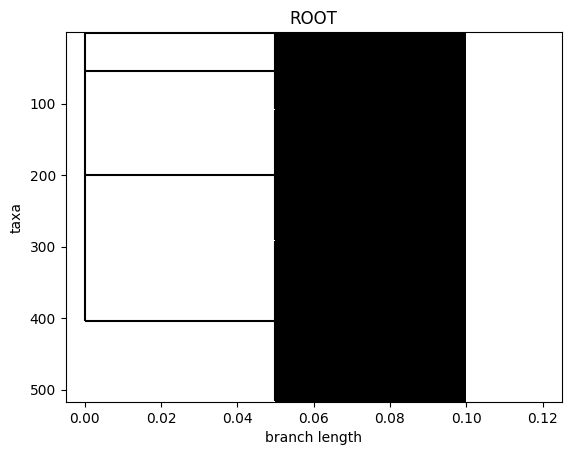

In [4]:
# compute a clustering from the unaligned sequences and a rough initial tree with short branches
clustering : pd.DataFrame = Clustering.compute_clustering(train_filename, cluster_seq_id=0.01, linear=False)
tree_handler = Clustering.cluster_tree(clustering, branch_length=0.05)
tree_handler.draw(no_labels=True)

In [5]:
# compute cluster precision
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   
trues = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        positives += int(u.parent == v.parent)
        trues += int(tu.parent == tv.parent)
        true_positives += int(u.parent == v.parent and tu.parent == tv.parent)

print("Cluster precision:", true_positives/positives)
print("Cluster recall:", true_positives/trues)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster precision: 1.0
Cluster recall: 0.9952878594316111
True number of clusters:  3
Predicted number of clusters:  4


In [6]:
def encoder_weight_extractor(encoder_model : tf.keras.Model):
   K = -3.0 # default value if no kernel is found
   num_models = 1
   for layer in encoder_model.layers:
      if layer.name.startswith("anc_probs_layer"):
         K = layer.time_kernel.numpy()
         num_models = layer.num_models
   return [Initializers.ConstantInitializer(K)] + Initializers.make_LG_init(num_models)

Warmup of 5 models.
Training of 5 models on file 3_200_short.unaligned.fa
Configuration: 
{
num_models : 5
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : Const(shape=(36,)) , match_to_end : Const(shape=(36,)) , 
    match_to_match : Const(shape=(35,)) , match_to_insert : Const(shape=(35,)) , 
    insert_to_match : Const(shape=(35,)) , insert_to_insert : Const(shape=(35,)) , 
    match_to_delete : Const(shape=(36,)) , delete_to_match : Const(shape=(36,)) , 
    delete_to_delete : Const(shape=(35,)) , left_flank_loop : Const(shape=(1,)) , 
    left_flank_exit : Const(shape=(1,)) , unannotated_segment_loop : Const(shape=(1,)) , 
    unannotated_segment_exit : Const(shape=(1,)) , right_flank_loop : Const(shape=(1,)) , 
    right_flank_exit : Const(shape=(1,)) , end_to_unannotated_segment : Const(shape=(1,)) , 
    end_to_right_flank : Const(shape=(1,)) , end_to_terminal : Const(shape=(1,))
    },
 flank_init=Const(shape=(1,)),
 prior=ProfileHMMTransitio

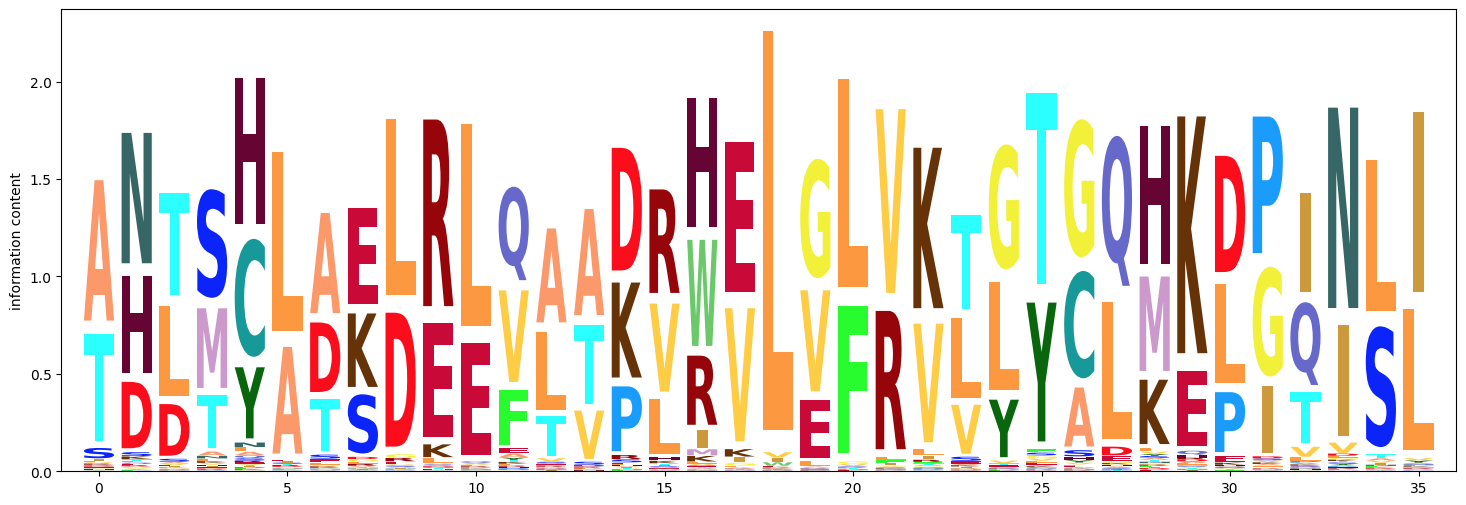

In [7]:
surgery_runs = 2
warmup_epochs = 5
use_tree_transitioner = False

out_filename = "test/data/interactive_alignment_tree.fasta"
with SequenceDataset(train_filename, fmt="fasta") as data:

    # warmup without tree 
    # this quickly learns an initial profile
    warmup_config = Configuration.make_default(num_models)
    # cropping
    warmup_config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) 
    # short initial model, focus on important sites
    warmup_config["len_mul"] = 0.8
    # no surgery, only a few epochs of warmup
    warmup_config["max_surgery_runs"] = 1
    warmup_config["epochs"][0] = warmup_epochs

    print("Warmup of", warmup_config["num_models"], "models.")

    warmup_alignment_model = Align.fit_and_align(data, warmup_config, verbose=False)
    warmup_emitter = warmup_alignment_model.msa_hmm_layer.cell.emitter[0]
    warmup_transitioner = warmup_alignment_model.msa_hmm_layer.cell.transitioner

    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    Visualize.plot_logo(warmup_alignment_model, 0, ax)

    cluster_factor = (tree_handler.num_anc-1) / data.num_seq
    config = Configuration.make_default(num_models, 
                                        tree_handler=tree_handler,
                                        tree_loss_weight=cluster_factor,
                                        use_tree_transitioner=use_tree_transitioner)

    # initialize with the warmup parameters
    config["emitter"].emission_init = []
    config["emitter"].insertion_init = []
    config["transitioner"].transition_init = []
    config["transitioner"].flank_init = []
    for i in range(num_models):
        config["emitter"].emission_init.append(Initializers.ConstantInitializer(warmup_emitter.emission_kernel[i].numpy()[np.newaxis,:,:]))
        config["emitter"].insertion_init.append(Initializers.ConstantInitializer(warmup_emitter.insertion_kernel[i].numpy()[np.newaxis,:]))
        trans_dict = {}
        config["transitioner"].transition_init.append(trans_dict)
        for key in warmup_transitioner.transition_kernel[0].keys():
            K = warmup_transitioner.transition_kernel[i][key].numpy()
            if use_tree_transitioner:
                K = K[np.newaxis,:]
            trans_dict[key] = Initializers.ConstantInitializer(K)
        F = warmup_transitioner.flank_init_kernel[i].numpy()
        if use_tree_transitioner:
            F = F[np.newaxis,:]
        config["transitioner"].flank_init.append(Initializers.ConstantInitializer(F))

    config["emission_kernel_dummy"] = warmup_emitter.emission_init[0]
    config["transition_kernel_dummy"] = warmup_transitioner.transition_init[0]
    config["flank_init_kernel_dummy"] = warmup_transitioner.flank_init[0]

    # main alignment with tree
    config["max_surgery_runs"] = surgery_runs
    config["len_mul"] = 1.0 if surgery_runs == 1 else 0.8

    # making these smaller than 50%, the default, is required to account for
    # insertions in smaller clusters or deletions in larger clusters
    config["surgery_ins"] = 0.2
    config["surgery_del"] = 0.2

    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["encoder_weight_extractor"] = encoder_weight_extractor
    config["model_criterion"] = "loglik_with_tree"
    
    initial_model_length_callback = partial(Align.get_initial_model_lengths, random=False)
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        initial_model_length_callback=lambda data, config : warmup_emitter.lengths,
                                        verbose=True,
                                        align_insertions=True,
                                        A2M_output=False) #required to sum fastSP

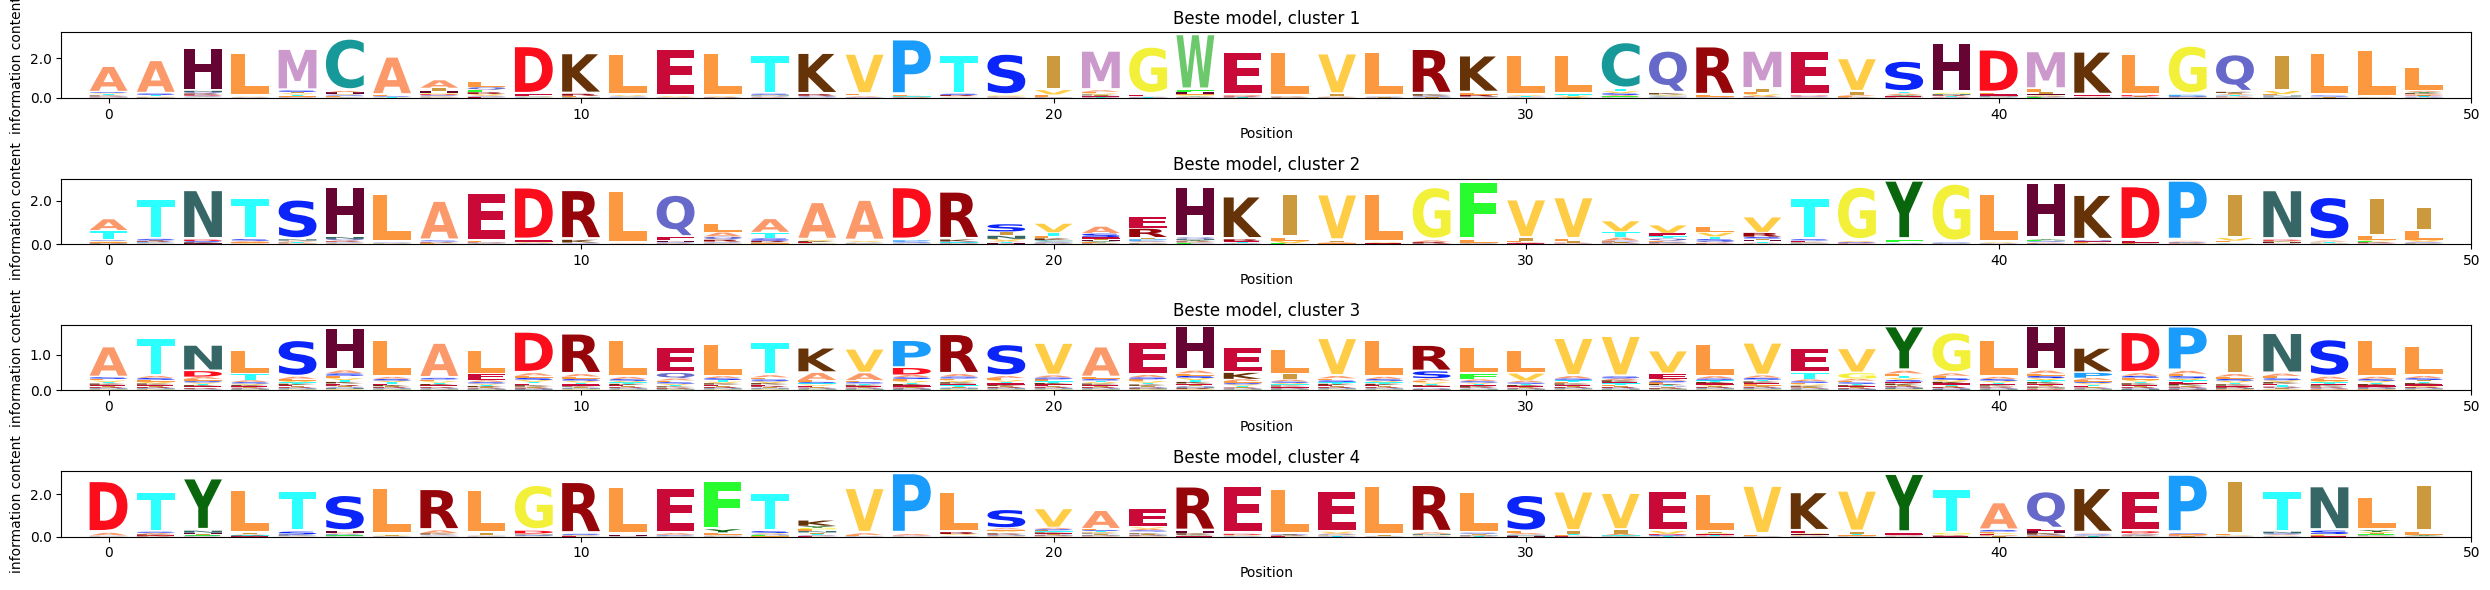

In [8]:
num_clust = tree_handler.num_anc-1
fig, axes = plt.subplots(num_clust, 1, figsize=(10, 5))
for i in range(num_clust):
    ax = axes[i]
    ax.set_title(f"Beste model, cluster {i+1}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Information content")
    Visualize.plot_logo(alignment_model, alignment_model.best_model, ax, cluster_index=i)
plt.tight_layout()

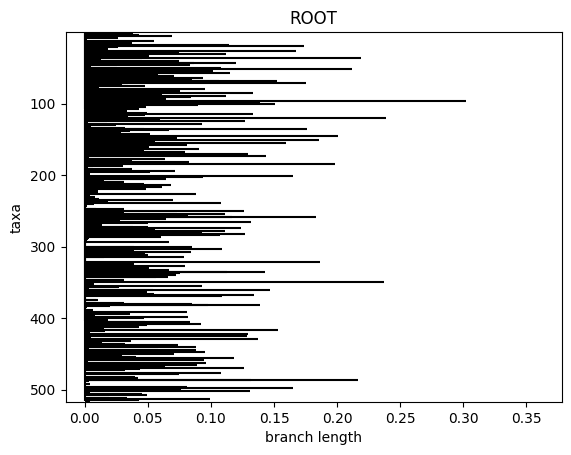

In [9]:
# plot the tree after training
# this requires to get both the branch lengths of the tree emitter for the ancestral past of the tree
# as well as the lengths of all leaf branches from the ancestral probability layer

# ancestral part
tree_emitter = alignment_model.msa_hmm_layer.cell.emitter[0]
branch_lengths = tree_emitter.get_branch_lengths().numpy()
branch_lengths = branch_lengths[:, alignment_model.best_model]
branch_lengths = branch_lengths[:, np.newaxis]

# leaf part
anc_prob_layer = alignment_model.encoder_model.layers[-3]
leaf_branch_lengths = anc_prob_layer.make_times().numpy()
leaf_branch_lengths = leaf_branch_lengths[:,alignment_model.best_model]
leaf_branch_lengths = leaf_branch_lengths[:,np.newaxis]

branch_lengths = np.concatenate((leaf_branch_lengths, branch_lengths), axis=0)

tree_emitter.tree_handler.set_branch_lengths(branch_lengths)
tree_emitter.tree_handler.draw(no_labels=True)

In [10]:
fastsp_bin = "../snakeMSA/FastSP/FastSP.jar"
!java -jar {fastsp_bin} -r {ref_filename} -e test/data/interactive_alignment_tree.fasta

Reference alignment: /home/felix/src/learnMSA/../trees/data/dev_msa/3_200_short.fa ...
Estimated alignment: /home/felix/src/learnMSA/test/data/interactive_alignment_tree.fasta ...
MaxLenNoGap= 65, NumSeq= 516, LenRef= 853, LenEst= 222, Cells= 554700
computing ...
Number of shared homologies: 2501065
Number of homologies in the reference alignment: 4668592
Number of homologies in the estimated alignment: 5063875
Number of correctly aligned columns: 0
Number of aligned columns in ref. alignment: 70
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 761 0
Number of aligned columns in est. alignment: 170
Number of singleton and (uncollapsed) insertion columns in est. alignment: 52 0
SP-Score 0.5357214766250724
Modeler 0.49390338426600183
SPFN 0.4642785233749276
SPFP 0.5060966157339981
Compression (naive) 0.26025791324736225
Compression 0.26714801444043323
TC 0.0
Time to compute (seconds): 0.058


In [11]:
#compute the cluster SP-scores
cluster_ids = true_tree.get_parent_indices_by_height(0)-true_tree.num_leaves
num_clust = np.max(cluster_ids)+1

cluster_ref_seqs = []
cluster_pred_seqs = []
for j in range(num_clust):
    cluster_ref_seqs.append([])
    cluster_pred_seqs.append([])

ref_data = SequenceDataset(ref_filename)
pred_data = SequenceDataset(out_filename)

for i,j in enumerate(cluster_ids):
    ref_seq = ref_data.get_standardized_seq(i, remove_gaps=False)
    pred_seq = pred_data.get_standardized_seq(i, remove_gaps=False)
    header = ref_data.get_header(i)
    assert header == pred_data.get_header(i)
    cluster_ref_seqs[j].append((header, ref_seq))
    cluster_pred_seqs[j].append((header, pred_seq))

ref_data.close()
pred_data.close()

for j in range(num_clust):

    cluster_ref_file_name = f"tmp/{j}_ref"
    with open(cluster_ref_file_name, "w") as cluster_ref_file:
        for header, seq in cluster_ref_seqs[j]:
            cluster_ref_file.write(">"+header+"\n")
            cluster_ref_file.write(seq+"\n")

    cluster_pred_file_name = f"tmp/{j}_pred"
    with open(cluster_pred_file_name, "w") as cluster_pred_file:
        for header, seq in cluster_pred_seqs[j]:
            cluster_pred_file.write(">"+header+"\n")
            cluster_pred_file.write(seq+"\n")

    print("Cluster", j)
    print("Size: ", len(cluster_pred_seqs[j]))
    !java -jar {fastsp_bin} -r {cluster_ref_file_name} -e {cluster_pred_file_name}

Cluster 0
Size:  183
Reference alignment: /home/felix/src/learnMSA/tmp/0_ref ...
Estimated alignment: /home/felix/src/learnMSA/tmp/0_pred ...
MaxLenNoGap= 65, NumSeq= 183, LenRef= 853, LenEst= 222, Cells= 196725
computing ...
Number of shared homologies: 752087
Number of homologies in the reference alignment: 782618
Number of homologies in the estimated alignment: 780151
Number of correctly aligned columns: 7
Number of aligned columns in ref. alignment: 50
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 325 0
Number of aligned columns in est. alignment: 119
Number of singleton and (uncollapsed) insertion columns in est. alignment: 58 0
SP-Score 0.9609886304685045
Modeler 0.9640274767320686
SPFN 0.03901136953149553
SPFP 0.03597252326793143
Compression (naive) 0.26025791324736225
Compression 0.472
TC 0.14
Time to compute (seconds): 0.034
Cluster 1
Size:  226
Reference alignment: /home/felix/src/learnMSA/tmp/1_ref ...
Estimated alignment: /home/felix/src/learnMS